# OOD detection applied to Hallucination Detection

 The goal is to predict if an INPUT prompt  is going to produce an hallucination or not (using OOD detection methods). For now, we don’t look at the output generated by the model, we may consider this in a second time. Retrieve ID samples:  To do this, take a general (easy) QA dataset containing questions along with their true hallucination-free answers. Feed the questions to the model. Let the model generate responses and check if the a given generated response is the same as the real hallucination-free answer. All the correct generated responses will be considered ID. More precisely, the ID dataset will consist of the embeddings of the last token of the last layer of the input (or maybe middle layer) of the correct generated responses.  Test a new sample to see if this is going to be OOD=hallucination: Take another dataset containing questions susceptible to trigger hallucinations along with the true hallucination-free answers (or no answer if the model cannot know the answer by any way and all response that the model might produce will necessarily be hallucinated). Feed a question to the model and let it generate a response. Check by comparing to the hallucination-free answer is that generated response is hallucinated or not. At the same time, apply an OOD detection method on the input question (at the last token last layer) and see if there is a correspondence between a high OOD score and a generated hallucination. 

In [1]:
# import libraries
# -----------------------------------
import torch
import sys
import time 
import os 
# Add the path to the src directory
sys.path.append(os.path.abspath(".."))

In [2]:
# Define global variables
# -----------------------------------
SEED = 44
BATCH_SIZE = 16 #32
MODEL_NAME = "meta-llama/Llama-2-7b-chat-hf"
OUTPUT_DIR = "../results/raw/"
PLOT_DIR   = "../results/figures/"
LAYER = 16    # integer
TOKENS = "Avg"  # string


from src.inference.activation_utils import (
    extract_last_token_activations,
    extract_average_token_activations,
    extract_max_token_activations
    )
if TOKENS=="-1":
    EXTRACT_TOKEN_ACTIVATIONS = extract_last_token_activations
elif TOKENS=="Avg":
    EXTRACT_TOKEN_ACTIVATIONS = extract_average_token_activations
elif TOKENS=="Max":
    EXTRACT_TOKEN_ACTIVATIONS = extract_max_token_activations

In [3]:
# Clear memory to avoid "CUDA out of memory"
# -----------------------------------
torch.cuda.empty_cache()
torch.cuda.ipc_collect()

In [4]:
# Visualize setup 
# -----------------------------------
print(f"Python version: {sys.version}")
print(f"Cuda version: {torch.version.cuda}")
num_gpus = torch.cuda.device_count()
print(f"Number of available de GPU : {num_gpus}")
for i in range(num_gpus):
    print(f"GPU {i + 1} : {torch.cuda.get_device_name(i)}")

Python version: 3.11.11 (main, Dec  4 2024, 08:55:07) [GCC 11.4.0]
Cuda version: 12.6
Number of available de GPU : 2
GPU 1 : NVIDIA GeForce RTX 4090
GPU 2 : NVIDIA GeForce RTX 4090


In [5]:
# Seed everything
# -----------------------------------
from src.utils.general import seed_all
seed_all(SEED)

## Load model

In [6]:
# Load model
# -----------------------------------
from src.model_loader.llama_loader import load_llama

model, tokenizer = load_llama(MODEL_NAME)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

## Load ID dataset

For the ID general dataset, we are going to use the SQUAD 1.1 dataset: 

***SQuAD 1.1:** Comprises over 100,000 question-answer pairs derived from more than 500 Wikipedia articles. Each question is paired with a specific segment of text (a span) from the corresponding article that serves as the answer.*

In [7]:
# Load ID dataset
# -----------------------------------
from src.data_reader.squad_loader import load_id_fit_dataset

id_fit_dataset = load_id_fit_dataset()
id_fit_dataset = id_fit_dataset.shuffle(SEED) 
id_fit_dataset = id_fit_dataset.slice(idx_start=0, idx_end=100)
id_fit_dataset.print_info()


===== Dataset Information =====
Dataset({
    features: ['id', 'title', 'context', 'question', 'answers', 'original_index', 'is_impossible'],
    num_rows: 100
})
Mean ground-truth answer length: 2.75, Max length: 16
Mean context + question length: 124.98, Max length: 269


In [8]:
# Visualize one generation with the ID dataset
# -----------------------------------
from src.inference.inference_utils import analyze_single_generation, build_prompt, get_layer_output, extract_last_token_activations

_ = analyze_single_generation(
    model=model,
    tokenizer=tokenizer, 
    dataset=id_fit_dataset,
    sample_idx=0,
    build_prompt_fn=build_prompt,
    get_layer_output_fn=get_layer_output,
    layer_idx=LAYER,
    extract_token_activations_fn=extract_last_token_activations,
    end_offset=-5
)

========= Analyze one generation  =========
----- Prompt construction: 0.000 sec
----- Tokenization: 0.003 sec


----- Token extraction: 0.391 sec
----- Generation: 0.609 sec
----- Decoding: 0.000 sec
----- Similarity scoring: 0.042 sec

=== Prompt ===
[INST] <<SYS>>
Just give the answer, without a complete sentence. Reply with 'Impossible to answer' if answer not in context.
<<SYS>>

Context:
Under a front page headline "The Truth", the paper printed allegations provided to them that some fans picked the pockets of crushed victims, that others urinated on members of the emergency services as they tried to help and that some even assaulted a police constable "whilst he was administering the kiss of life to a patient." Despite the headline, written by Kelvin MacKenzie, the story was based on allegations either by unnamed and unattributable sources, or hearsay accounts of what named individuals had said – a fact made clear to MacKenzie by Harry Arnold, the reporter who wrote the story.

Question:
What was the story based on?

Answer:
[/INST]

=== Shapes ===
Shape - number of tokens: torch.Size([1, 

## Retrieve ID embeddings

In [9]:
# Compute offsets to select the tokens to give to the model
# -----------------------------------
from src.inference.inference_utils import compute_token_offsets, build_prompt
idx = 67
text = build_prompt(id_fit_dataset[idx]["context"], id_fit_dataset[idx]["question"])
start_offset, end_offset = compute_token_offsets(
    text=text,
    tokenizer=tokenizer,
    start_phrase="\nContext:",
    end_phrase="Answer:\n",
    debug=True)

===== Input text =====
[INST] <<SYS>>
Just give the answer, without a complete sentence. Reply with 'Impossible to answer' if answer not in context.
<<SYS>>

Context:
Many of the leading universities associated with Enlightenment progressive principles were located in northern Europe, with the most renowned being the universities of Leiden, Göttingen, Halle, Montpellier, Uppsala and Edinburgh. These universities, especially Edinburgh, produced professors whose ideas had a significant impact on Britain's North American colonies and, later, the American Republic. Within the natural sciences, Edinburgh's medical also led the way in chemistry, anatomy and pharmacology. In other parts of Europe, the universities and schools of France and most of Europe were bastions of traditionalism and were not hospitable to the Enlightenment. In France, the major exception was the medical university at Montpellier.

Question:
Which university, especially, produced professors whose ideas had a significant

In [34]:
# Retrieve ID embeddings and save results 
# -----------------------------------
from src.inference.inference_utils import (batch_extract_token_activations_with_generation, build_prompt, get_layer_output)
from src.utils.general import print_time_elapsed

# Runs batched inference on a dataset using a decoder-only language model.
# For each batch, generates answers, computes semantic similarity scores, extracts token-level activations,
# and appends the results to a pickle file.
print("\nStart retrieving ID embeddings...")
t0 = time.time()
batch_extract_token_activations_with_generation(
    model=model,
    tokenizer=tokenizer,
    dataset=id_fit_dataset,
    batch_size=BATCH_SIZE,
    idx_start_sample=0,
    max_samples=len(id_fit_dataset),
    output_path = OUTPUT_DIR + f"id_fit_results_layer{LAYER}_token{TOKENS}.pkl",
    build_prompt_fn=build_prompt,
    get_layer_output_fn=get_layer_output,
    layer_idx=LAYER,  
    extract_token_activations_fn=EXTRACT_TOKEN_ACTIVATIONS,
    start_offset=start_offset,
    end_offset=end_offset
)
t1 = time.time()
print("...end!")
print_time_elapsed(t0, t1, label="ID embeddings: ")


Start retrieving ID embeddings...


100%|██████████| 7/7 [00:13<00:00,  1.91s/it]

...end!
ID embeddings: Time elapsed: 00 min 13 sec



In [18]:
# Free memory 
del id_fit_dataset

## Load OOD/Hallucinations test datasets 

To evaluate the Hallucination detection in question answering using OOD detection methods, we will use datasets in the SQuAD style:

***SQuAD 2.0:** SQuAD 2.0 extends the original **SQuAD 1.1** dataset by adding around 50,000 unanswerable questions. These questions are carefully designed to look similar to answerable ones, making it more challenging for models to determine when there isn’t enough information in the context to provide an answer.*

**Test Dataset Composition** \
Our test set will include two types of samples:
- ***Impossible samples***: Questions that cannot be answered based on the provided context (i.e., the answer is not present in the text). These are taken from the training split of SQuAD 2.0, selecting only the unanswerable questions.
- ***Possible samples***: Questions where the answer is explicitly present in the context. These are drawn from the validation split of SQuAD 1.1. This ensures there is no overlap with the in-distribution (ID) data from the SQuAD 1.1 training split.

**Note on Evaluation Scope**\
Currently, our evaluation focuses on whether the model can answer questions using only the information provided in the input context. We do not test the model’s internal knowledge or ability to answer questions without supporting context. However, this setup closely matches the OOD scenario: if the information is not in the text, the model should recognize and indicate this.

**Additional Dataset: TriviaQA**\
To further test generalization, we will also use the TriviaQA dataset. Like SQuAD, TriviaQA provides question-answering prompts with supporting context. The model must either extract the correct answer from the context or correctly identify when the answer is not present.


In [19]:
# Load test datasets
# -----------------------------------
from src.data_reader.squad_loader import load_id_test_dataset, load_od_test_dataset

# Load possible test dataset 
id_test_dataset = load_id_test_dataset()
id_test_dataset = id_test_dataset.shuffle(SEED) 
id_test_dataset = id_test_dataset.slice(idx_start=0, idx_end=1000)
id_test_dataset.print_info()

# Load impossible test dataset 
od_test_dataset = load_od_test_dataset()
od_test_dataset = od_test_dataset.shuffle(SEED) 
od_test_dataset = od_test_dataset.slice(idx_start=0, idx_end=1000)
od_test_dataset.print_info()



===== Dataset Information =====
Dataset({
    features: ['id', 'title', 'context', 'question', 'answers', 'original_index', 'is_impossible'],
    num_rows: 1000
})
Mean ground-truth answer length: 2.94, Max length: 25
Mean context + question length: 132.44, Max length: 513

===== Dataset Information =====
Dataset({
    features: ['id', 'title', 'context', 'question', 'answers', 'original_index', 'is_impossible'],
    num_rows: 1000
})
No valid ground-truth answers to compute length stats.
Mean context + question length: 129.01, Max length: 451


In [ ]:
# Visualize one generation with the test impossible dataset
# -----------------------------------
from src.inference.inference_utils import analyze_single_generation, build_impossible_prompt, get_layer_output, extract_last_token_activations

_ = analyze_single_generation(
    model=model,
    tokenizer=tokenizer, 
    dataset=od_test_dataset,
    sample_idx=500,
    build_prompt_fn=build_impossible_prompt,
    get_layer_output_fn=get_layer_output,
    layer_idx=LAYER,
    extract_token_activations_fn=extract_last_token_activations,
    end_offset=-5
)

========= Analyze one generation  =========
----- Prompt construction: 0.000 sec
----- Tokenization: 0.018 sec
----- Token extraction: 0.038 sec
----- Generation: 0.076 sec
----- Decoding: 0.000 sec
----- Similarity scoring: 0.004 sec

=== Prompt ===
[INST]

Just give the answer, without a complete sentence. Reply with 'Impossible to answer' if answer not in context.

Context:
In the Catholic Church, canon law is the system of laws and legal principles made and enforced by the Church's hierarchical authorities to regulate its external organization and government and to order and direct the activities of Catholics toward the mission of the Church.

Question:
What mission this Canon law directly activities of all Christians towards?

Answer:
[/INST]

=== Shapes ===
Shape - number of tokens: torch.Size([1, 117])
Shape - selected_layer: torch.Size([1, 117, 4096])

=== Generated Answer ===
Mission

=== Ground-truth Answer ===


=== Similarity Scores ===
ROUGE-L F1: 0.0000
Sentence-BERT Cosi

## Retrieve test embeddings 

Test embeddings which may be OOD/Hallucinations.

In [21]:
# Retrieve test embeddings and save results 
# -----------------------------------
from src.inference.inference_utils import batch_extract_token_activations, build_prompt, get_layer_output, extract_last_token_activations
from src.utils.general import print_time_elapsed

# Runs batched inference on a dataset using a decoder-only language model.
# For each batch, gextracts token-level activations, and appends the results to a pickle file.
print("\nStart retrieving test impossible embeddings...")
t2 = time.time()
batch_extract_token_activations(
    model=model,
    tokenizer=tokenizer,
    dataset=od_test_dataset,
    batch_size=BATCH_SIZE,
    idx_start_sample=0,
    max_samples=len(od_test_dataset),
    save_to_pkl = True,
    output_path = OUTPUT_DIR + f"od_test_results_layer{LAYER}_token{TOKENS}.pkl",
    build_prompt_fn=build_prompt,
    get_layer_output_fn=get_layer_output,
    layer_idx=LAYER,  
    extract_token_activations_fn=EXTRACT_TOKEN_ACTIVATIONS,
    start_offset=start_offset,
    end_offset=end_offset
)
t3 = time.time()
print("...end!")
print_time_elapsed(t2, t3, label="Test impossible embeddings: ")


print("\nStart retrieving test possible embeddings...")
t4 = time.time()
batch_extract_token_activations(
    model=model,
    tokenizer=tokenizer,
    dataset=id_test_dataset,
    batch_size=BATCH_SIZE,
    idx_start_sample=0,
    max_samples=len(id_test_dataset),
    save_to_pkl = True,
    output_path = OUTPUT_DIR + f"id_test_results_layer{LAYER}_token{TOKENS}.pkl",
    build_prompt_fn=build_prompt,
    get_layer_output_fn=get_layer_output,
    layer_idx=LAYER,  
    extract_token_activations_fn=EXTRACT_TOKEN_ACTIVATIONS,
    start_offset=start_offset,
    end_offset=end_offset
)
t5 = time.time()
print("...end!")
print_time_elapsed(t4, t5, label="Test possible embeddings: ")


Start retrieving test impossible embeddings...


100%|██████████| 32/32 [00:53<00:00,  1.66s/it]


...end!
Test impossible embeddings: Time elapsed: 00 min 53 sec


Start retrieving test possible embeddings...


100%|██████████| 32/32 [00:53<00:00,  1.67s/it]

...end!
Test possible embeddings: Time elapsed: 00 min 53 sec



In [22]:
# Free memory 
del od_test_dataset 
del id_test_dataset

## Load extracted embeddings 

In [46]:
# Load ID embeddings 
# -----------------------------------
from src.data_reader.pickle_io import load_pickle_batches
from src.utils.general import filter_correct_entries

# Load extracted embeddings 
id_fit_embeddings = load_pickle_batches(OUTPUT_DIR + f"id_fit_results_layer{LAYER}_token{TOKENS}.pkl")
# Only keep rows with simiar generated and ground-truth answers
id_fit_embeddings = filter_correct_entries(id_fit_embeddings) 
# Concatenate all embeddings 
#id_fit_embeddings = torch.cat(id_fit_embeddings['activations'], dim=0) # shape: [N, D]


Loaded 10000 samples from: ../results/raw/id_fit_results_layer16_tokenAvg.pkl
Size before filtering incorrect samples: 10000.
Size after filtering: 7420. Filtered 2580 samples.


In [6]:
# Load test embeddings 
# -----------------------------------
from src.data_reader.pickle_io import load_pickle_batches

# Load extracted possible and impossible embeddings 
od_test_embeddings = load_pickle_batches(OUTPUT_DIR + f"id_test_results_layer{LAYER}_token{TOKENS}.pkl")
id_test_embeddings = load_pickle_batches(OUTPUT_DIR + f"od_test_results_layer{LAYER}_token{TOKENS}.pkl")
# Concatenate possible and impossible all embeddings 
od_test_embeddings = torch.cat(od_test_embeddings['activations'], dim=0) # shape: [N, D]
id_test_embeddings = torch.cat(id_test_embeddings['activations'], dim=0) # shape: [N, D]

Loaded 1000 samples from: ../results/raw/id_test_results_layer16_tokenAvg.pkl
Loaded 1000 samples from: ../results/raw/od_test_results_layer16_tokenAvg.pkl


## Perform DKNN

In [7]:
# Clear memory to avoid "CUDA out of memory"
# -----------------------------------
torch.cuda.empty_cache()
torch.cuda.ipc_collect()

In [8]:
# Constructs the FAISS index from ID data.
# -----------------------------------
from src.analysis.dknn import fit_to_dataset
index = fit_to_dataset(id_fit_embeddings, use_gpu=True)

In [11]:
# Compute DKNN scores on test data
# -----------------------------------
from src.analysis.dknn import score_tensor
k=5
dknn_scores_id  = score_tensor(index, id_test_embeddings, nearest=k, batch_size=BATCH_SIZE)
dknn_scores_ood = score_tensor(index, od_test_embeddings, nearest=k, batch_size=BATCH_SIZE)

auROC: 0.5670


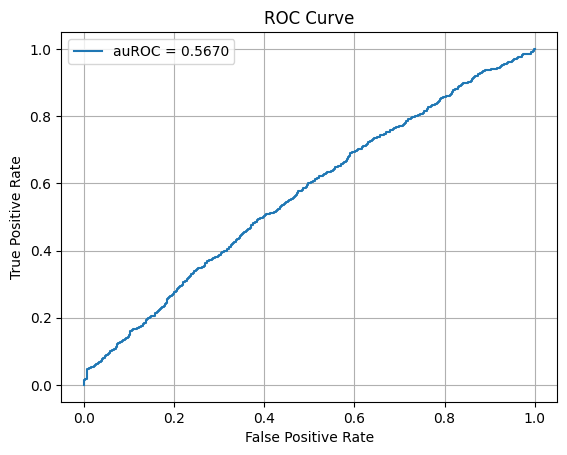

AUROC: 0.5670


In [13]:
# Compute and plot auroc 
# -----------------------------------
from src.analysis.dknn import compute_auroc
auroc, fpr, tpr, thresholds = compute_auroc(
    dknn_scores_id, 
    dknn_scores_ood, 
    plot=True,
    save_path= PLOT_DIR + f"roc_layer{LAYER}_token{TOKENS}_k{k}.png"
)
print(f"AUROC: {auroc:.4f}")

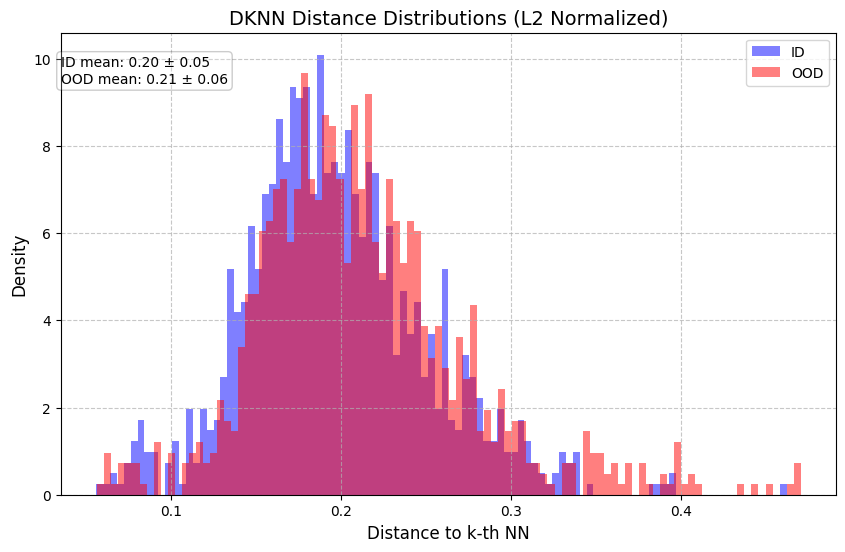

In [14]:
# Plot ID and OOD distributions 
# -----------------------------------
from src.analysis.dknn import plot_score_distributions
plot_score_distributions(
    dknn_scores_id=dknn_scores_id,
    dknn_scores_ood=dknn_scores_ood,
    bins=100,
    title="DKNN Distance Distributions (L2 Normalized)",
    save_path = PLOT_DIR + f"densities_layer{LAYER}_token{TOKENS}_k{k}.png"
)


:'(

# Brouillon

In [7]:
import torch
from src.model_loader.llama_loader import load_llama

# Load model and tokenizer 
model, tokenizer = load_llama(MODEL_NAME)
model.eval() 

def get_layer_output(
    model,
    inputs,
    layer_idx,
) -> torch.Tensor:
    """
    Run a forward pass and extract the hidden states from a specific transformer layer
    (more memory-efficient than using output_hidden_states=True).
    Transformer layer = self-attention + FFN + normalization.

    Parameters
    ----------
    model : PreTrainedModel
        A Hugging Face causal language model (e.g., LLaMA, GPT-2).
    inputs : dict
        Tokenized inputs returned by a tokenizer with return_tensors="pt".
    layer_idx : int
        Index of the transformer block to capture:
        - Use 0 to N-1 for internal layers.
        - Use -1 to retrieve the final transformer block (not logits).

    Returns
    -------
    torch.Tensor
        Hidden states from the selected transformer layer.
        Shape: (batch_size, seq_len, hidden_size)
    """
    # If layer_idx = -1, interpret as "last transformer block"
    if layer_idx == -1:
        layer_idx = len(model.model.layers) - 1  # last layer index

    captured_hidden = {} # store the activation retrieved by the hook

    def hook_fn(module, input, output):
        """Function called automatically by PyTorch just after 
        the layer has produced its output during the forward pass."""
        # output is a tuple (hidden_states,) -> keep [0]
        captured_hidden["layer_output"] = output[0]
        #captured_hidden["layer_output"] = model.model.norm(output[0])  # post RMSNorm!


    # Register hook on the transformer block
    # When Pytorch pass through this layer during forward pass, it also execute hook_fn.
    handle = model.model.layers[layer_idx].register_forward_hook(hook_fn)

    # Pass inputs through the model
    # When the target layer is reached, the hook executes and saves its output in captured_hidden.
    with torch.no_grad():
        _ = model(**inputs, return_dict=True)

    # Remove the hook to avoid polluting future passages
    handle.remove()

    if "layer_output" not in captured_hidden:
        raise RuntimeError(f"Layer {layer_idx} did not produce an output.")

    return captured_hidden["layer_output"]  # shape: (batch_size, seq_len, hidden_size)


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Some parameters are on the meta device because they were offloaded to the cpu.


In [9]:
from src.utils.general import seed_all
seed_all(44)

prompt = "The capital of France is"

inputs = tokenizer(prompt, return_tensors="pt").to(model.device)
print("Number of tokens in the prompt:", len(inputs["input_ids"][0]))
print("Inputs tokens:", inputs["input_ids"][0])

# Define witch layer to retrieve 
layer_idx = -1  # Last layer

# METHOD 1: Retrieve token embeddings with model.generate 
# =========================================
with torch.no_grad():
    outputs = model.generate(
            **inputs,
            max_new_tokens=50,
            output_hidden_states=True,
            return_dict_in_generate=True,
            do_sample=True,
            temperature=0.6,
            top_p=0.9,
            top_k=50,
            use_cache=False, 
            eos_token_id=tokenizer.eos_token_id,
            pad_token_id=tokenizer.eos_token_id 
        )
"""
Rappel sur la forme de output_hidden_states: 
-----
Quand on appelle model.generate(..., output_hidden_states=True), 
la variable outputs.hidden_states est une liste (ou un tuple) où:

Le premier élément (indice 0) contient les embeddings (hidden states) 
de tous les tokens du prompt (avant génération).
Sa forme est (batch_size, prompt_len, hidden_size).

Chaque élément suivant (indice 1, 2, 3, ...) contient les embeddings 
du token généré à cette étape uniquement.
Sa forme est (batch_size, 1, hidden_size) car c'est un seul token.

Donc, si on a un prompt de 6 tokens et que l'on génère 3 tokens, on aura:
# L = numéro de la couche (ex: -1 pour la dernière)
outputs.hidden_states[0][L]  -> embeddings des 6 tokens du prompt (shape: [1, 6, hidden_size]) 
outputs.hidden_states[1][L]  -> embeddings du 1er token généré (shape: [1, 1, hidden_size])
outputs.hidden_states[2][L]  -> embeddings du 2e token généré (shape: [1, 1, hidden_size])
outputs.hidden_states[3][L]  -> embeddings du 3e token généré (shape: [1, 1, hidden_size])

len(outputs.hidden_states[0]) = Number of layers
"""

# Complete generated sequence (prompt + response)
generated_ids = outputs.sequences  # Shape - (1, prompt_len + gen_len) = (1, 6+50) = (1, 56)
print("generated_ids:", generated_ids)
full_text = tokenizer.decode(generated_ids[0])
print("Full generated text (full_text):\n", full_text)
print("\n\n")

# Extract hidden states from model.generate 
gen_hidden = []
for step in range(len(outputs.hidden_states)): # Shape - len(outputs.hidden_states) = 50
    # Shape - outputs.hidden_states[step][layer_idx] = (1, 1, hidden_size)
    gen_hidden.append(outputs.hidden_states[step][layer_idx][0, 0, :]) 
gen_hidden = torch.stack(gen_hidden, dim=0)  # (gen_len, hidden_size)
print("gen_hidden.shape", gen_hidden.shape)

# METHOD 2: Retrieve embeddings with complete forward + hook 
# => This is the method I am using so far in my code in batch_extract_answer_token_activations() from inference_utils.py
# =========================================
# 1. We take full_text[4:] to remove the '<s> ' appended by the tokenizer 
# so that embeddings from METHOD 1 and 2 can be aligned and thus compared 
# 2. We retokenize the full generated text so that we can have access to the attention mask and pass
# it to get_layer_output like I did in batch_extract_answer_token_activations()
full_inputs = tokenizer(full_text[4:], return_tensors="pt").to(model.device)
print("full_inputs:", full_inputs)
full_hidden = get_layer_output(model, full_inputs, layer_idx)[0]  # (seq_len, hidden_size) = (50, 4096) # 0 to select batch=1
print("full_hidden.shape", full_hidden.shape)


# Alignment and comparison
# =========================================
prompt_len = inputs["input_ids"].shape[1]  
full_hidden_gen = full_hidden[prompt_len:prompt_len+gen_hidden.shape[0], :]  # (gen_len, hidden_size) = (56, 4096)
print("full_hidden_gen.shape", full_hidden_gen.shape)


# Force the same device
device = model.device if hasattr(model, "device") else next(model.parameters()).device
gen_hidden = gen_hidden.to(device)
full_hidden_gen = full_hidden_gen.to(device)
# Compute difference
diff = torch.norm(full_hidden_gen - gen_hidden, dim=1)
print("Norm of difference for each generated token:", diff)
# Compute cosine_sim to see if vectors point in the same direction
cosine_sim = torch.nn.functional.cosine_similarity(full_hidden_gen, gen_hidden, dim=1)
print("Cosine similarity per step:", cosine_sim)
print("All close?", torch.allclose(full_hidden_gen, gen_hidden, atol=1e-5))


Number of tokens in the prompt: 6
Inputs tokens: tensor([   1,  450, 7483,  310, 3444,  338], device='cuda:0')
generated_ids: tensor([[    1,   450,  7483,   310,  3444,   338,  3681, 29889,    13,  2177,
           275,   338,   278, 10150,  4272,   297,  3444,   322,   338,  2998,
           363,   967,   380, 27389, 11258, 29892,  1616, 19133, 29879, 29892,
           322, 15839,  2982, 22848, 29889,  3834,   310,   278,  1556, 13834,
         19650,  1953,   297,  3681,  3160,   278,   382,  2593,   295, 23615,
         29892,   278,  4562, 12675,  6838, 29892]], device='cuda:0')
Full generated text (full_text):
 <s> The capital of France is Paris.
Paris is the largest city in France and is known for its stunning architecture, art museums, and historical landmarks. Some of the most famous attractions in Paris include the Eiffel Tower, the Louvre Museum,



gen_hidden.shape torch.Size([50, 4096])
full_inputs: {'input_ids': tensor([[    1,   450,  7483,   310,  3444,   338,  3681, 29

**Pourquoi c'est différent entre model.generate et forward complet + hook ?**


On voit que la norme 2 est différente et la cosine similarity est proche de 0 et négative ce qui indique que les vecteurs sont quasiment orthogonaux et de sens opposés.
Un utilisateur a déjà repporté ce probleme:
- en Nov 2024 pour GPT2 : https://discuss.huggingface.co/t/gpt2-hidden-states-get-by-output-hidden-states-is-different-from-those-by-register-forward-hook/125835

- Dans la définition de hook_fn, faut-il que je mette: 
captured_hidden["layer_output"] = output[0] ou captured_hidden["layer_output"] = model.model.norm(output[0])  # post RMSNorm!
    - Dans le code Llama, chaque bloc (LlamaDecoderLayer) applique : RMSNorm => SelfAttention (avec causal mask) => résiduel => RMSNorm => MLP => résiduel.
    - Moi dans mon forward + hook je fais: Blocs LlamaDecoderLayer: RMSNorm => SelfAttention (avec causal mask) => résiduel => RMSNorm => MLP => résiduel. Puis je refais RMSNorm final (model.model.norm) et je capture ce tenseur. 
    De toutes façons que je mette output[0] ou model.model.norm(output[0]), model.generate et forward diffèrent. 

Ce qui est identique entre model.generate et le forward complet + hook : 
- Que ce soit pour model.generate ou pour le forward complet, le masque d'attention causal est appliqué dans les deux cas. En effet, comme pour model.generate, lors d’un forward pass complet, chaque token ne peut "voir" que les tokens précédents grâce au masque causal. Ainsi, l’attention utilise systématiquement le masque causal : chaque token ne peut donc porter attention qu’aux tokens précédents ou à lui-même donc il ne devrait pas y avoir de différence à ce niveau entre forward et model.generate 
- Que ce soit avec model.generate ou lors d’un forward complet, la normalisation (RMSNorm/LayerNorm) est toujours appliquée séparément à chaque token (RMSNorm ne dépend pas de la longueur de séquence ni du contexte global)

Mes hypothèses sur ce qui peut différer :
- Une différence pourrait venir du cache (past_key_values) car lors de model.generate, les clés/valeurs d'attention sont réutilisées alors que c'est pas le cas pour le forward complet. Je te joins plus tard mon petit test 
sur le cache où l'on observe des résultats très différents avec ou sans utlisation du cache. 
Cependant, je mets ici use_cache = False, j'ai toujours cette différence entre model.generate() et le forward + hook. 

- RMSNorm  est utilisé dans LLaMA 2 à la place du LayerNorm classique. Cette normalisation s’applique indépendamment sur chaque vecteur de token en sortant de chaque bloc Transformer, en normalisant par la norme quadratique des composantes du vecteur. En soi, RMSNorm ne dépend pas de la longueur de séquence ni du contexte global : que l’on traite un token isolé ou une séquence complète, le calcul du RMSNorm d’une étape donnée devrait être le même pour ce token. Cependant, la moindre variation numérique en entrée du RMSNorm sera amplifiée (puisqu’on divise par une moyenne quadratique) et propagée aux couches suivantes. Ainsi, si les vecteurs avant normalisation diffèrent ne serait-ce que légèrement, les sorties RMSNorm différeront encore plus. 

- Les embeddings de position (RoPE) sont incrémentés étape par étape lors de la génération, alors qu’ils sont calculés d’un coup lors du forward complet. Ceci pourrait créer une différence. 


- Quelques sources supplémentaires : 
    - "During the generation step, you're not doing 1 forward pass, but say 256 passes for 256 new tokens. Each token must be generated, hence its 256x slower. [...] They find the closest token and do a different forward pass each time, instead of using the caches previous hidden states in a regular forward pass." (https://www.reddit.com/r/LocalLLaMA/comments/1aplei9/why_is_modelgenerate_so_much_for_inference_so/)

    - "The two methods do something completely different.
        - Calling the model (which means the forward method) uses the labels for teacher forcing. This means inputs to the decoder are the labels shifted by one. With teacher forcing, the decoder always gets the ground-truth token in the next step, no matter what the prediction was. Teacher forcing is used from model training, all steps are fully differentiable.
        - When you call the generate method, the model is used in the autoregressive fashion. Any token it generates is put as the input in the next step. However, selecting the token is a "hard" decision, and the gradient cannot be propagated through this decision. The generate method cannot be used for training. The output is coherent because the decoder reacts to what was previously generated.
        - With teacher forcing, the model might want to prefer generating a token and continue consistently with the generated token. However, it cannot continue consistently, because it is forced to continue as if it generated the token that actually is in the labels argument. This why you observe the incoherent output (which was nevertheless never intended to be output but only to be used for training)." 
        (https://stackoverflow.com/questions/67328345/how-to-use-forward-method-instead-of-model-generate-for-t5-model)


In [36]:
from src.utils.general import seed_all
seed_all(44)
model = model.float() # Pass the model to float32

with torch.no_grad():
    outputs_cache = model.generate(
            **inputs,
            max_new_tokens=50,
            output_hidden_states=True,
            return_dict_in_generate=True,
            do_sample=False,
            temperature=1,
            #top_p=0.9,
            #top_k=50,
            use_cache=True, 
            eos_token_id=tokenizer.eos_token_id,
            pad_token_id=tokenizer.eos_token_id 
        )
    
# Extract hidden states from model.generate 
gen_hidden_cache = []
for step in range(len(outputs_cache.hidden_states)): # Shape - len(outputs.hidden_states) = 50
    gen_hidden_cache.append(outputs_cache.hidden_states[step][layer_idx][0, 0, :]) 
gen_hidden_cache = torch.stack(gen_hidden_cache, dim=0)  # (gen_len, hidden_size)
print("gen_hidden_cache: ", gen_hidden_cache)


with torch.no_grad():
    outputs_nocache = model.generate(
            **inputs,
            max_new_tokens=50,
            output_hidden_states=True,
            return_dict_in_generate=True,
            do_sample=False,
            temperature=1,
            #top_p=0.9,
            #top_k=50,
            use_cache=False, 
            eos_token_id=tokenizer.eos_token_id,
            pad_token_id=tokenizer.eos_token_id 
        )
    
# Extract hidden states from model.generate 
gen_hidden_Nocache = []
for step in range(len(outputs_nocache.hidden_states)): 
    gen_hidden_Nocache.append(outputs_nocache.hidden_states[step][layer_idx][0, 0, :]) 
gen_hidden_Nocache = torch.stack(gen_hidden_Nocache, dim=0)  # (gen_len, hidden_size)
print("gen_hidden_Nocache", gen_hidden_Nocache)

# Dettect if cache or not makes a difference 
diff = torch.norm(gen_hidden_cache - gen_hidden_Nocache, dim=1)
print("Norm of difference for each generated token:", diff)
print("All close?", torch.allclose(gen_hidden_cache, gen_hidden_Nocache, atol=1e-5))

# Compute cosine_sim to see if vectors point in the same direction
cosine_sim = torch.nn.functional.cosine_similarity(gen_hidden_cache, gen_hidden_Nocache, dim=1)
print("Cosine similarity per step:", cosine_sim)

# Do the 2 methods generate the same tokens? 
print("Same tokens generated?", torch.equal(outputs_cache.sequences, outputs_nocache.sequences))



/home/lila.roig/.env/ood_env/lib/python3.11/site-packages/transformers/generation/configuration_utils.py:636: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.9` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(


gen_hidden_cache:  tensor([[ 2.8545e-01, -7.6011e-02,  1.3866e-02,  ...,  1.6535e-02,
          1.7483e-03,  3.5943e-02],
        [ 1.3763e+00, -2.0311e+00, -5.9080e-01,  ..., -7.7493e-01,
          1.4942e+00,  1.2476e+00],
        [ 1.3237e+00,  1.1104e+00,  2.2428e+00,  ..., -1.1177e+00,
          4.9294e-01,  1.8590e+00],
        ...,
        [ 5.5895e-01, -6.7917e-01, -1.8643e+00,  ...,  1.8280e+00,
          7.3041e-01,  4.5444e-01],
        [ 7.5555e-01, -2.9025e-01, -2.2392e+00,  ...,  1.1273e+00,
         -9.9765e-01, -1.2817e+00],
        [ 5.6314e-01, -2.3225e+00, -1.5054e-01,  ...,  1.4187e-02,
          2.8200e-01,  1.4845e+00]], device='cuda:0')
gen_hidden_Nocache tensor([[ 0.2855, -0.0760,  0.0139,  ...,  0.0165,  0.0017,  0.0359],
        [ 0.2855, -0.0760,  0.0139,  ...,  0.0165,  0.0017,  0.0359],
        [ 0.2855, -0.0760,  0.0139,  ...,  0.0165,  0.0017,  0.0359],
        ...,
        [ 0.2855, -0.0760,  0.0139,  ...,  0.0165,  0.0017,  0.0359],
        [ 0.2855, -0

Ici on voit une différence notable entre use_cache=True et use_cache=False entre les deux runs de model.generate(), meme si je passe le modèle en float 32. 
En fait, quand use_cache=False chaque étape de génération recalcule toute la séquence précédente à chaque pas. 
Cela signifie que des petites erreurs apparaissent très tôt, et elles se propagent et s’accumulent exponentiellement sur 50 étapes de génération. D'ailleurs on voit que pour le premier step la norme de la différence est 0 et ensuite elle s'accumule très vite. Même quand on supprime toute stochasticité avec le seed, en mettant do_sample=False (greedy decoding) temperature=1, et en supprimant top_p=0.9 et top_k=50 on a une différence. 
Bien sur si on met pour les 2 ruens de model.generate() use_cache=True ou use_cache=False on a pas de différence. 
Mais peut-être que la distance L2 n'est pas la distance la plus pertinente car elle ne fait que mesurer la norme des vecteurs. Donc je regarde avec la cosine similarity si les vecteurs pointent dans le meme sens. Pour rappel: cos_sim= +1 => les deux vecteurs pointent exactement dans la même direction, cos_sim = 0 => vecteurs orthogonaux, aucune similarité directionnelle et cos_sim = -1 vecteirs se sens opposés. Et on voit que l'on a des cosine faibles et négatives, indiquant des vecteurs opposés dans l’espace latent et absence de similarité directionnelle.
Cependant, on constate que les tokens générés sont identiques. 

Ce probleme de différence a déjà été rapporté ici 
- En 2023: https://github.com/huggingface/transformers/issues/25420 : "When using KV caches (and, in some models, left-padding), we are changing the input shape to some matrix multiplication operations. For instance, in Llama, when you apply the linear projection to obtain the QKV for the attention layer, the input shape will be different depending on whether you're using left-padding and/or KV caches. Therefore, the output of these operations may be different, and these tiny differences build up across layers and across generated tokens, especially at lower resolutions." 
- en mars 2025 pour "Llama-3.1-8B-Instruct" : https://discuss.huggingface.co/t/model-generate-use-cache-true-generates-different-results-than-use-cache-false/144001 

In [ ]:
# Mettre un hook sur le generate
# Regarder d'autres codes pour comprendre pourquoi 
# pour obtenir les hidden states du prompt + génération, les conseillers recommandent exactement cela : faire un forward sur le prompt initial puis utiliser generate pour les sorties, puis combiner
 # Comment modifier mon code pour avoir input hidden states + generated: https://discuss.huggingface.co/t/the-hidden-states-when-i-use-model-generate/73169/3

In [102]:

import torch
from src.model_loader.llama_loader import load_llama
from src.utils.general import seed_all

# Clear memory to avoid "CUDA out of memory"
# -----------------------------------
torch.cuda.empty_cache()
torch.cuda.ipc_collect()

seed_all(44)

MODEL_NAME = "meta-llama/Llama-2-7b-chat-hf"

# Load model and tokenizer
model, tokenizer = load_llama(MODEL_NAME)
model.eval()


def get_layer_output(
    model,
    inputs,
    layer_idx,
) -> torch.Tensor:
    """
    Run a forward pass and extract the hidden states from a specific transformer layer
    (more memory-efficient than using output_hidden_states=True).
    Transformer layer = self-attention + FFN + normalization.

    Parameters
    ----------
    model : PreTrainedModel
        A Hugging Face causal language model (e.g., LLaMA, GPT-2).
    inputs : dict
        Tokenized inputs returned by a tokenizer with return_tensors="pt".
    layer_idx : int
        Index of the transformer block to capture:
        - Use 0 to N-1 for internal layers.
        - Use -1 to retrieve the final transformer block (not logits).

    Returns
    -------
    torch.Tensor
        Hidden states from the selected transformer layer.
        Shape: (batch_size, seq_len, hidden_size)
    """

    captured_hidden = {}  # store the activation retrieved by the hook

    def hook_fn(module, input, output):
        """Function called automatically by PyTorch just after
        the layer has produced its output during the forward pass."""
        # output is a tuple (hidden_states,) -> keep [0]
        if layer_idx == -1:
            captured_hidden["layer_output"] = model.model.norm(output[0])  # post RMSNorm!
        else:
            captured_hidden["layer_output"] = output[0]

    # Register hook on the transformer block
    # When Pytorch pass through this layer during forward pass, it also execute hook_fn.
    handle = model.model.layers[layer_idx].register_forward_hook(hook_fn)

    # Pass inputs through the model
    # When the target layer is reached, the hook executes and saves its output in captured_hidden.
    with torch.no_grad():
        _ = model(**inputs, return_dict=True)

    # Remove the hook to avoid polluting future passages
    handle.remove()

    if "layer_output" not in captured_hidden:
        raise RuntimeError(f"Layer {layer_idx} did not produce an output.")

    return captured_hidden["layer_output"]  # shape: (batch_size, seq_len, hidden_size)


prompt = "The capital of France is"

inputs = tokenizer(prompt, return_tensors="pt").to(model.device)
print("Number of tokens in the prompt:", len(inputs["input_ids"][0]))
print("Inputs tokens:", inputs["input_ids"][0])

# Define witch layer to retrieve
layer_idx = -1  # Last layer

# METHOD 1: Retrieve token embeddings with model.generate
# =========================================
with torch.no_grad():
    outputs = model.generate(
        **inputs,
        max_new_tokens=50,
        output_hidden_states=True,
        return_dict_in_generate=True,
        do_sample=True,
        temperature=0.6,
        top_p=0.9,
        top_k=50,
        num_beams = 1,
        use_cache=False,
        eos_token_id=tokenizer.eos_token_id,
        pad_token_id=tokenizer.eos_token_id,
    )


print("Length of outputs.hidden_states:", len(outputs.hidden_states))


print("Checking the shape of the hidden states:")
print("Length of outputs.hidden_states[0]:", len(outputs.hidden_states[0]))
print(
    "Shape of outputs.hidden_states[0][layer_idx]:",
    outputs.hidden_states[0][layer_idx].shape,
)
print(
    "Shape of outputs.hidden_states[1][layer_idx]:",
    outputs.hidden_states[1][layer_idx].shape,
)
print(
    "Shape of outputs.hidden_states[2][layer_idx]:",
    outputs.hidden_states[2][layer_idx].shape,
)
print(
    "Shape of outputs.hidden_states[-1][layer_idx]:",
    outputs.hidden_states[-1][layer_idx].shape,
)

# Complete generated sequence (prompt + response)
generated_ids = (
    outputs.sequences
)  # Shape - (1, prompt_len + gen_len) = (1, 6+50) = (1, 56)
print("generated_ids:", generated_ids)
full_text = tokenizer.decode(generated_ids[0])
print("Full generated text (full_text):\n", full_text)
print("\n\n")

# Extract hidden states from model.generate
gen_hidden = []
for step in range(
    len(outputs.hidden_states)
):  # Shape - len(outputs.hidden_states) = 50
    # Shape - outputs.hidden_states[step][layer_idx] = (1, 1, hidden_size)
    gen_hidden.append(outputs.hidden_states[step][layer_idx][0, -1, :])
gen_hidden = torch.stack(gen_hidden, dim=0)  # (gen_len, hidden_size)
print("gen_hidden.shape", gen_hidden.shape)

# METHOD 2: Retrieve embeddings with complete forward + hook
# => This is the method I am using so far in my code in batch_extract_answer_token_activations() from inference_utils.py
# =========================================
# 1. We take full_text[4:] to remove the '<s> ' appended by the tokenizer
# so that embeddings from METHOD 1 and 2 can be aligned and thus compared
# 2. We retokenize the full generated text so that we can have access to the attention mask and pass
# it to get_layer_output like I did in batch_extract_answer_token_activations()
full_inputs = tokenizer(full_text[4:], return_tensors="pt").to(model.device)
print("full_inputs:", full_inputs)
full_hidden = get_layer_output(model, full_inputs, layer_idx)[
    0
]  # (seq_len, hidden_size) = (50, 4096) # 0 to select batch=1
print("full_hidden.shape", full_hidden.shape)


# Alignment and comparison
# =========================================
prompt_len = inputs["input_ids"].shape[1]
full_hidden_gen = full_hidden[
    prompt_len : prompt_len + gen_hidden.shape[0], :
]  # (gen_len, hidden_size) = (56, 4096)
print("full_hidden_gen.shape", full_hidden_gen.shape)


# Force the same device
device = model.device if hasattr(model, "device") else next(model.parameters()).device
gen_hidden = gen_hidden.to(device)
full_hidden_gen = full_hidden_gen.to(device)
# Compute difference
diff = torch.norm(full_hidden_gen[:-1] - gen_hidden[1:], dim=1)
print("Norm of difference for each generated token:", diff)
# Compute cosine_sim to see if vectors point in the same direction
cosine_sim = torch.nn.functional.cosine_similarity(
    full_hidden_gen[:-1], gen_hidden[1:], dim=1
)
print("Cosine similarity per step:", cosine_sim)
print("All close?", torch.allclose(full_hidden_gen, gen_hidden, atol=1e-5))

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Number of tokens in the prompt: 6
Inputs tokens: tensor([   1,  450, 7483,  310, 3444,  338], device='cuda:0')
Length of outputs.hidden_states: 50
Checking the shape of the hidden states:
Length of outputs.hidden_states[0]: 33
Shape of outputs.hidden_states[0][layer_idx]: torch.Size([1, 6, 4096])
Shape of outputs.hidden_states[1][layer_idx]: torch.Size([1, 7, 4096])
Shape of outputs.hidden_states[2][layer_idx]: torch.Size([1, 8, 4096])
Shape of outputs.hidden_states[-1][layer_idx]: torch.Size([1, 55, 4096])
generated_ids: tensor([[    1,   450,  7483,   310,  3444,   338,  3681, 29889,    13,  2177,
           275,   338,   278, 10150,  4272,   297,  3444,   322,   338,  2998,
           363,   967,   380, 27389, 11258, 29892,  1616, 19133, 29879, 29892,
           322, 15839,  2982, 22848, 29889,  3834,   310,   278,  1556, 13834,
         19650,  1953,   297,  3681,  3160,   278,   382,  2593,   295, 23615,
         29892,   278,  4562, 12675,  6838, 29892]], device='cuda:0')
Full ge

In [34]:
def generate_answers_with_hook(
    model,
    inputs,
    tokenizer,
    layer_idx,
    max_new_tokens=50
):
    activations = []

    def hook_fn(module, input, output):
        # Stocke tous les embeddings du layer pour chaque forward 
        if layer_idx == -1:
            activations.append( model.model.norm(output[0]).detach().cpu()) # post RMSNorm!
        else:
            activations.append(output[0].detach().cpu())


    handle = model.model.layers[layer_idx].register_forward_hook(hook_fn)

    with torch.no_grad():
        output_ids = model.generate(
            **inputs,
            max_new_tokens=max_new_tokens,
            do_sample=True,
            temperature=0.6,
            top_p=0.9,
            top_k=50,
            eos_token_id=tokenizer.eos_token_id,
            pad_token_id=tokenizer.eos_token_id,
        )

    handle.remove()

    # activations est une liste de tenseurs (batch_size, seq_len, hidden_size)
    # Il faudra les organiser selon la logique de génération (voir plus haut)
    return output_ids, activations


In [128]:
# CODE OK 

torch.cuda.empty_cache()
torch.cuda.ipc_collect()

k_beams=1

import time
def print_time_elapsed(start, end, label=""):
    elapsed = end - start
    mins, secs = divmod(elapsed, 60)
    print(f"{label}Time elapsed: {int(mins):07d} min {int(secs):07d} sec\n")


OUTPUT_HIDDEN_STATES = True

t0 = time.time()


prompt = [
    "The capital of France is",
    "What is the name of the French Queen who was decapitated?",
    "Tell me why the sky is blue?"
]


inputs = tokenizer(prompt, return_tensors="pt", padding=True).to(model.device)
print("Number of tokens in the prompt:", len(inputs["input_ids"][0]))
print("Inputs tokens:", inputs["input_ids"][0])

# Define witch layer to retrieve
layer_idx = -1  # Last layer


activations = []

def hook_fn(module, input, output):
    # Stocke tous les embeddings du layer pour chaque forward
    if layer_idx == -1:
        activations.append( model.model.norm(output[0]).detach().cpu()) # post RMSNorm!
    else:
        activations.append(output[0].detach().cpu())
        

handle = model.model.layers[layer_idx].register_forward_hook(hook_fn)

with torch.no_grad():
    outputs = model.generate(
        **inputs,
        max_new_tokens=50,
        output_hidden_states=OUTPUT_HIDDEN_STATES,
        return_dict_in_generate=OUTPUT_HIDDEN_STATES,
        do_sample=True,
        temperature=0.6,
        top_p=0.9,
        top_k=50,
        num_beams = k_beams,
        use_cache=True,
        eos_token_id=tokenizer.eos_token_id,
        pad_token_id=tokenizer.eos_token_id,
)

handle.remove()

# activations est une liste de tenseurs (batch_size, seq_len, hidden_size)
# Il faudra les organiser selon la logique de génération (voir plus haut)

if OUTPUT_HIDDEN_STATES:
    print("Length of outputs.hidden_states:", len(outputs.hidden_states))

    print("Checking the shape of the hidden states:")
    print("Length of outputs.hidden_states[0]:", len(outputs.hidden_states[0]))
    print(
        "Shape of outputs.hidden_states[0][layer_idx]:",
        outputs.hidden_states[0][layer_idx].shape,
    )
    print(
        "Shape of outputs.hidden_states[1][layer_idx]:",
        outputs.hidden_states[1][layer_idx].shape,
    )
    print(
        "Shape of outputs.hidden_states[2][layer_idx]:",
        outputs.hidden_states[2][layer_idx].shape,
    )
    print(
        "Shape of outputs.hidden_states[-1][layer_idx]:",
        outputs.hidden_states[-1][layer_idx].shape,
    )

print("=======================================")
print("Length of activations:", len(activations))
print("Shape of activations[0]:", activations[0].shape)  # [3, 15, 4096]

print("Checking the shape of the hidden states:")
print("Length of activations[0]:", len(activations[0]))
print(
    "Shape of activations[0]:",
    activations[0].shape,
)
print(
    "Shape of activations[1]:",
    activations[1].shape,
)
print(
    "Shape of activations[2]:",
    activations[2].shape,
)
print(
    "Shape of activations[-1]:",
    activations[-1].shape,
)

if OUTPUT_HIDDEN_STATES:
    # Complete generated sequence (prompt + response)
    generated_ids = (
        outputs.sequences
    )  # Shape - (1, prompt_len + gen_len) = (1, 6+50) = (1, 56)
    print("generated_ids:", generated_ids)
    full_text = tokenizer.decode(generated_ids[0])
    print("Full generated text (full_text):\n", full_text)
    print("\n\n")


# METHOD 1: Retrieve token embeddings with model.generate
# =========================================
# Extract hidden states from model.generate
if OUTPUT_HIDDEN_STATES:
    gen_hidden = []
    for step in range(
        len(outputs.hidden_states)
    ):  # Shape - len(outputs.hidden_states) = 50
        # Shape - outputs.hidden_states[step][layer_idx] = (1, 1, hidden_size)
        gen_hidden.append(outputs.hidden_states[step][layer_idx][:, -1, :])
    gen_hidden = torch.stack(gen_hidden, dim=0)  # (gen_len, hidden_size)
    print("gen_hidden.shape", gen_hidden.shape)


# METHOD 2: Retrieve token embeddings with model.generate + hook
# =========================================
# Pour chaque forward, on veut le dernier token généré
hook_hidden = []
for step in range(len(activations)):
    # activations[step] : (batch, seq_len, hidden_size)
    # On prend le dernier token de la séquence générée à cette étape
    hook_hidden.append(activations[step][:, -1, :])
hook_hidden = torch.stack(hook_hidden, dim=0)  # (gen_len, hidden_size)
print("hook_hidden.shape", hook_hidden.shape)


# Alignment and comparison
# =========================================
# S'assurer que les tenseurs sont sur le même device
if OUTPUT_HIDDEN_STATES:
    gen_hidden = gen_hidden.to(hook_hidden.device)

    # Calculer la norme de la différence pour chaque token généré
    diff = torch.norm(gen_hidden - hook_hidden, dim=1)
    print("Norm of difference for each generated token:", diff)

    # Calculer la similarité cosinus
    cosine_sim = torch.nn.functional.cosine_similarity(gen_hidden, hook_hidden, dim=1)
    print("Cosine similarity per step:", cosine_sim)

    # Vérifier si les résultats sont identiques (à une tolérance numérique près)
    print("All close?", torch.allclose(gen_hidden, hook_hidden, atol=1e-5))


t1 = time.time()
print_time_elapsed(t0, t1, label="Inference time: ")

Number of tokens in the prompt: 15
Inputs tokens: tensor([   2,    2,    2,    2,    2,    2,    2,    2,    2,    1,  450, 7483,
         310, 3444,  338], device='cuda:0')
Length of outputs.hidden_states: 50
Checking the shape of the hidden states:
Length of outputs.hidden_states[0]: 33
Shape of outputs.hidden_states[0][layer_idx]: torch.Size([3, 15, 4096])
Shape of outputs.hidden_states[1][layer_idx]: torch.Size([3, 1, 4096])
Shape of outputs.hidden_states[2][layer_idx]: torch.Size([3, 1, 4096])
Shape of outputs.hidden_states[-1][layer_idx]: torch.Size([3, 1, 4096])
Length of activations: 50
Shape of activations[0]: torch.Size([3, 15, 4096])
Checking the shape of the hidden states:
Length of activations[0]: 3
Shape of activations[0]: torch.Size([3, 15, 4096])
Shape of activations[1]: torch.Size([3, 1, 4096])
Shape of activations[2]: torch.Size([3, 1, 4096])
Shape of activations[-1]: torch.Size([3, 1, 4096])
generated_ids: tensor([[    2,     2,     2,     2,     2,     2,     2,    

Avec le code ci-dessus, on voit que utiliser `model.generate()` donne les memes résultats que utiliser un `hook` durant le generate. Ceci est sutout vrai pour le dernier layer et plus on va dans les premiers layers et plus il y a une différence entre `model.generate()` et le `hook`.  Que je mette `use_cache=True` ou `use_cache=False` on a bien `model.generate()` qui donne les mêmes sorties que le `hook`.

In [ ]:
# Semble ok pour le beam search et attention mask de la génération
# maintenant il faut l'adapter pour activations car pour le moment c'est fait que pour 
# output.hidden_states
# ==========================
import torch
import time

torch.cuda.empty_cache()
torch.cuda.ipc_collect()

k_beams = 2

def print_time_elapsed(start, end, label=""):
    elapsed = end - start
    mins, secs = divmod(elapsed, 60)
    print(f"{label}Time elapsed: {int(mins):07d} min {int(secs):07d} sec\n")

t0 = time.time()

prompts = [
    "The capital of France is",
    "What is the name of the French Queen who was decapitated?",
    "Tell me why the sky is blue?",
    "What is the color of the eyes of Elisabeth Taylor? (answer one word)"
]

inputs = tokenizer(prompts, return_tensors="pt", padding=True).to(model.device)
batch_size = inputs["input_ids"].shape[0]
print("Number of tokens in the prompt:", len(inputs["input_ids"][0]))
print("Inputs tokens:", inputs["input_ids"][0])

layer_idx = -1  # Last layer

activations = []

def hook_fn(module, input, output):
    if layer_idx == -1:
        activations.append(model.model.norm(output[0]).detach().cpu())
    else:
        activations.append(output[0].detach().cpu())

handle = model.model.layers[layer_idx].register_forward_hook(hook_fn)

with torch.no_grad():
    outputs = model.generate(
        **inputs,
        max_new_tokens=50,
        output_hidden_states=True,
        return_dict_in_generate=True,
        do_sample=True,
        temperature=0.6,
        top_p=0.9,
        top_k=50,
        num_beams=k_beams,
        use_cache=False,
        eos_token_id=tokenizer.eos_token_id,
        pad_token_id=tokenizer.eos_token_id,
    )

handle.remove()

print("=======================================")

print("Length of outputs.hidden_states:", len(outputs.hidden_states))
print("Shape of outputs.hidden_states[0][layer_idx]:", outputs.hidden_states[0][layer_idx].shape)
print("Shape of outputs.hidden_states[1][layer_idx]:", outputs.hidden_states[1][layer_idx].shape)
print("Shape of outputs.hidden_states[-1][layer_idx]:", outputs.hidden_states[-1][layer_idx].shape)

print("Length of activations:", len(activations))
print("Shape of activations[0]:", activations[0].shape)
print("Shape of activations[1]:", activations[1].shape)
print("Shape of activations[-1]:", activations[-1].shape)

print("=======================================")
generated_ids = outputs.sequences
print("generated_ids:", generated_ids)
print("\n\n")
for s in generated_ids:
    full_text = tokenizer.decode(s)
    print("Full prompt + generated text (full_text):\n", full_text)
print("=======================================")
print("\n\n")

# Extraction vectorisée des hidden states alignés (méthode 2)
gen_len = outputs.beam_indices.shape[1] # = len(activations) = len(outputs.hidden_states)
hidden_size = outputs.hidden_states[0][layer_idx].shape[-1]
# hidden_states corresponding to the selected beam 
aligned_hidden_states = torch.zeros((batch_size, gen_len, hidden_size), dtype=outputs.hidden_states[0][layer_idx].dtype)

for step in range(gen_len):
    # hidden_states[step][layer_idx]: (batch_size * k_beams, seq_len, hidden_size)
    h = outputs.hidden_states[step][layer_idx]  # (batch_size * k_beams, seq_len, hidden_size)
    beam_indices = outputs.beam_indices[:, step].to(h.device)  # (batch_size,)
    valid = beam_indices >= 0
    if valid.any():
        aligned_hidden_states = aligned_hidden_states.to(h.device) 
        aligned_hidden_states[valid, step, :] = h[beam_indices[valid], -1, :]  # (batch_size_valid, hidden_size)
        # -1: last token generated at this step for each beam selected.

print("aligned_hidden_states.shape:", aligned_hidden_states.shape)
# aligned_hidden_states contains for each prompt in the batch and 
# for each generation step, the hidden state vector associated with the last token 
# generated for the sequence selected by the beam search.

# aligned_hidden_states[i] contient les embeddings alignés pour le prompt i

t1 = time.time()
print_time_elapsed(t0, t1, label="Inference time: ")


# Construction of the generation_mask
# Assumes that during generation all sequences are padded with the EOS token, and not with random tokens. 
# =====================================
prompt_len = inputs["input_ids"].shape[1] # Assumes all prompts are padded to the same length
gen_only_ids = generated_ids[:, prompt_len:] # Shape: (batch_size, gen_len)
batch_size, gen_len = gen_only_ids.shape

# Initialize the generation mask to identify which tokens are padded during generation
# Positions will be marked as True up to and including the first eos_token_id
generation_mask = torch.zeros((batch_size, gen_len), dtype=torch.bool, device=gen_only_ids.device)

eos_token_id = tokenizer.eos_token_id

# Create a boolean mask of where eos_token_id appears in the generated tokens
eos_mask = (gen_only_ids == eos_token_id) # Shape: (batch_size, gen_len) 

# Initialize a tensor with max length for each sequence = gen_len
# (meaning: if there is no eos, we consider the whole sequence as valid)
eos_positions = torch.full((batch_size,), gen_len, dtype=torch.long, device=gen_only_ids.device)

# Find which sequences actually contain at least one eos_token_id
any_eos = eos_mask.any(dim=1) # Shape: (batch_size,) -> True where at least one eos is found

# For sequences that contain an eos_token_id, find the index of its first occurrence
# Note: .float().argmax(dim=1) works because True -> 1.0, False -> 0.0
# So argmax will return the first position where eos_token_id == True
eos_positions[any_eos] = eos_mask[any_eos].float().argmax(dim=1)

# Create a tensor with position indices: [0, 1, 2, ..., gen_len - 1], repeated for each batch item
position_ids = torch.arange(gen_len, device=gen_only_ids.device).unsqueeze(0).expand(batch_size, -1) # Shape: (batch_size, gen_len)

# Build the final generation mask by marking positions as True
# for all positions up to and including the first eos_token_id
generation_mask = position_ids <= eos_positions.unsqueeze(1)

print("generation_mask:", generation_mask)

# IL faudra gérer le padding ensuite 
# et notamment le padding de la génération 
# Sauf que mes fonctions extract_average_token_activations, extract_last_token_activations et extract_max_token_activations
# supposent qu'un seul type de padding et souvent left. Or, moi si je cree un attention mask de la génération
# il y aura de right padding car la génération est right padded. 
# donc il faudra a mon avis modifier les fonctions extract_..._token_activations pour gérer ces cas. 
# ou alors je padde la réponse générée à gauche mais c'est moins propre


Number of tokens in the prompt: 17
Inputs tokens: tensor([   2,    2,    2,    2,    2,    2,    2,    2,    2,    2,    2,    1,
         450, 7483,  310, 3444,  338], device='cuda:0')
Length of outputs.hidden_states: 50
Shape of outputs.hidden_states[0][layer_idx]: torch.Size([8, 17, 4096])
Shape of outputs.hidden_states[1][layer_idx]: torch.Size([8, 18, 4096])
Shape of outputs.hidden_states[-1][layer_idx]: torch.Size([8, 66, 4096])
Length of activations: 100
Shape of activations[0]: torch.Size([8, 17, 4096])
Shape of activations[1]: torch.Size([8, 17, 4096])
Shape of activations[-1]: torch.Size([8, 66, 4096])
generated_ids: tensor([[    2,     2,     2,     2,     2,     2,     2,     2,     2,     2,
             2,     1,   450,  7483,   310,  3444,   338,  3681, 29889,   739,
           338,  5982,   297,   278, 11683,   280, 29899,   311, 29899, 16066,
          5120,   322,   338,  2998,   363,   967,   380, 27389, 11258, 29892,
          1616, 19133, 29879, 29892, 13460, 29892

In [112]:
outputs.hidden_states[0][layer_idx].dtype
activations[0].dtype

torch.float16

In [ ]:
import torch

torch.cuda.empty_cache()
torch.cuda.ipc_collect()

k_beams = 2


prompts = [
    "The capital of France is",
    "What is the name of the French Queen who was decapitated?",
    "Tell me why the sky is blue?",
    "What is the color of the eyes of Elisabeth Taylor? (answer one word)"
]

inputs = tokenizer(prompts, return_tensors="pt", padding=True).to(model.device)
batch_size = inputs["input_ids"].shape[0]
print("Number of tokens in the prompt:", len(inputs["input_ids"][0]))
print("Inputs tokens:", inputs["input_ids"][0])

layer_idx = -1  # Last layer

activations = []
# The hook plays the role of `output_hidden_states=True` and `return_dict_in_generate=True`
# in `model.generate()` but it is faster and more memory efficient because we retrieve exactly
# the actiavtions wanted. 
def hook_fn(module, input, output):
    """Function called automatically by PyTorch just after
        the layer has produced its output during the forward pass."""
    # output is a tuple (hidden_states,) → keep [0]
    if layer_idx == -1:
        activations.append(model.model.norm(output[0]).detach().cpu()) # post RMSNorm!
    else:
        activations.append(output[0].detach().cpu())

handle = model.model.layers[layer_idx].register_forward_hook(hook_fn)

with torch.no_grad():
    outputs = model.generate(
        **inputs,
        max_new_tokens=50,
        output_hidden_states=False, # hook will do the job of ` output_hidden_states=True` in a more efficient way
        return_dict_in_generate=True,
        do_sample=True,
        temperature=0.6,
        top_p=0.9,
        top_k=50,
        num_beams=k_beams,
        use_cache=False,
        eos_token_id=tokenizer.eos_token_id,
        pad_token_id=tokenizer.eos_token_id,
    )

handle.remove()

print("=======================================")

print("Length of activations:", len(activations))
print("Shape of activations[0]:", activations[0].shape)
print("Shape of activations[1]:", activations[1].shape)
print("Shape of activations[-1]:", activations[-1].shape)

print("=======================================")
generated_ids = outputs.sequences
print("generated_ids:", generated_ids)
print("\n\n")
for s in generated_ids:
    full_text = tokenizer.decode(s)
    print("Full prompt + generated text (full_text):\n", full_text)
print("=======================================")
print("\n\n")

# Extraction vectorisée des hidden states alignés (méthode 2)
gen_len = outputs.beam_indices.shape[1] # = len(activations)
hidden_size = activations[0].shape[-1]
# hidden_states corresponding to the selected beam 
aligned_hidden_states = torch.zeros((batch_size, gen_len, hidden_size), dtype=activations[0].dtype)

for step in range(gen_len):
    h = activations[step] # Shape (batch_size * k_beams, seq_len, hidden_size)
    beam_indices = outputs.beam_indices[:, step].to(h.device)  # Shape (batch_size,)
    valid = beam_indices >= 0
    if valid.any():
        aligned_hidden_states = aligned_hidden_states.to(h.device) 
        aligned_hidden_states[valid, step, :] = h[beam_indices[valid], -1, :]  # Shape (batch_size_valid, hidden_size)
        # -1: last token generated at this step for each beam selected.

print("aligned_hidden_states.shape:", aligned_hidden_states.shape) 
# aligned_hidden_states contains for each prompt in the batch and 
# for each generation step, the hidden state vector associated with the last token 
# generated for the sequence selected by the beam search.

# Construction of the generation_mask
# Assumes that during generation all sequences are padded with the EOS token, and not with random tokens. 
# =====================================
prompt_len = inputs["input_ids"].shape[1] # Assumes all prompts are padded to the same length
gen_only_ids = generated_ids[:, prompt_len:] # Shape: (batch_size, gen_len)

# Initialize the generation mask to identify which tokens are padded during generation
# Positions will be marked as True up to and including the first eos_token_id
generation_mask = torch.zeros((batch_size, gen_len), dtype=torch.bool, device=gen_only_ids.device)

eos_token_id = tokenizer.eos_token_id

# Create a boolean mask of where eos_token_id appears in the generated tokens
eos_mask = (gen_only_ids == eos_token_id) # Shape: (batch_size, gen_len) 

# Initialize a tensor with max length for each sequence = gen_len
# (meaning: if there is no eos, we consider the whole sequence as valid)
eos_positions = torch.full((batch_size,), gen_len, dtype=torch.long, device=gen_only_ids.device)

# Find which sequences actually contain at least one eos_token_id
any_eos = eos_mask.any(dim=1) # Shape: (batch_size,) -> True where at least one eos is found

# For sequences that contain an eos_token_id, find the index of its first occurrence
# Note: .float().argmax(dim=1) works because True -> 1.0, False -> 0.0
# So argmax will return the first position where eos_token_id == True
eos_positions[any_eos] = eos_mask[any_eos].float().argmax(dim=1)

# Create a tensor with position indices: [0, 1, 2, ..., gen_len - 1], repeated for each batch item
position_ids = torch.arange(gen_len, device=gen_only_ids.device).unsqueeze(0).expand(batch_size, -1) # Shape: (batch_size, gen_len)

# Build the final generation mask by marking positions as True
# for all positions up to and including the first eos_token_id
generation_mask = position_ids <= eos_positions.unsqueeze(1)

print("generation_mask:", generation_mask)

# IL faudra gérer le padding ensuite 
# et notamment le padding de la génération 
# Sauf que mes fonctions extract_average_token_activations, extract_last_token_activations et extract_max_token_activations
# supposent qu'un seul type de padding et souvent left. Or, moi si je cree un attention mask de la génération
# il y aura de right padding car la génération est right padded. 
# donc il faudra a mon avis modifier les fonctions extract_..._token_activations pour gérer ces cas. 
# ou alors je padde la réponse générée à gauche mais c'est moins propre


Number of tokens in the prompt: 17
Inputs tokens: tensor([   2,    2,    2,    2,    2,    2,    2,    2,    2,    2,    2,    1,
         450, 7483,  310, 3444,  338], device='cuda:0')
Length of activations: 50
Shape of activations[0]: torch.Size([8, 17, 4096])
Shape of activations[1]: torch.Size([8, 18, 4096])
Shape of activations[-1]: torch.Size([8, 66, 4096])
generated_ids: tensor([[    2,     2,     2,     2,     2,     2,     2,     2,     2,     2,
             2,     1,   450,  7483,   310,  3444,   338,  3681, 29889,   739,
           338,  5982,   297,   278, 11683,   280, 29899,   311, 29899, 16066,
          5120,   322,   338,  2998,   363,   967, 16375, 29892, 15839, 29892,
           322,  1616,  4695,   902, 16639, 29889,   450,  4272,   338,  3271,
           304,  1784, 13834,  2982, 22848,  1316,   408,   278,   382,  2593,
           295, 23615, 29892,   278,  4562, 12675,  6838],
        [    2,     2,     1,  1724,   338,   278,  1024,   310,   278,  5176,
       

In [34]:
from transformers import PreTrainedModel
from typing import List
import torch
from torch.utils.hooks import RemovableHandle



def hook_generation_activations(
    model: PreTrainedModel,
    activations_list: List[torch.Tensor],
    layer_idx: int = -1
) -> RemovableHandle:
    """
    Attaches a forward hook to a specific transformer layer to capture hidden states
    during autoregressive text generation (i.e., at each decoding step).

    Parameters
    ----------
    model : PreTrainedModel
        The Hugging Face causal language model (e.g., GPT, LLaMA).
    activations_list : List[torch.Tensor]
        A list that will be filled with hidden states for each generation step. 
        Each tensor has shape (batch_size * num_beams, seq_len, hidden_size).
    layer_idx : int
        Index of the transformer block to hook. Defaults to -1 (the last layer).
        Use a positive integer if you want to hook an intermediate layer instead.

    Returns
    ----------
    RemovableHandle : A handle object
        Call `handle.remove()` after generation to remove the hook.
    
    """
    call_counter = torch.tensor(0)

    def hook_fn(module, input, output):
        """Function called automatically by PyTorch just after
            the layer has produced its output during the forward pass."""
        # output is a tuple (hidden_states,) → keep [0]

        nonlocal call_counter
        call_counter += 1  # count how many times the hook is triggered
        
        if layer_idx == -1:
            # Capture the final normalized output 
            activations.append(model.model.norm(output[0]).detach().cpu())  # post RMSNorm!
        else:
            # Capture raw hidden states before layer normalization
            activations.append(output[0].detach().cpu()) ###### ????? ######
    
    # Register hook on the transformer block
    # When Pytorch pass through this layer during forward pass, it also execute hook_fn.
    handle = model.model.layers[layer_idx].register_forward_hook(hook_fn)
    
    return handle, call_counter

## FAUT IL FAIRE QQCH POUR calculer le layer comme avec get_layer_output ? 



from transformers import PreTrainedModel, PreTrainedTokenizer, BatchEncoding
from typing import Union, Dict
import torch


def generate(
    model: PreTrainedModel,
    inputs: BatchEncoding,
    tokenizer: PreTrainedTokenizer,
    max_new_tokens: int = 50,
    k_beams: int = 1,
    **generate_kwargs
) -> Union[torch.Tensor, Dict[str, torch.Tensor]]:
    """
    Generate sequences from the model with optional beam search.
    Supports advanced options via **generate_kwargs (e.g., output_attentions).

    Parameters
    ----------
    model : PreTrainedModel
        The language model to use for generation.
    inputs : BatchEncoding
        Tokenized input prompts.
    tokenizer : PreTrainedTokenizer
        Tokenizer providing eos and pad token IDs.
    max_new_tokens : int, optional
        Maximum number of new tokens to generate.
    k_beams : int, optional
        Number of beams to use. If 1, uses sampling. If >1, beam search is enabled.
    **generate_kwargs : dict
        Additional keyword arguments passed to `model.generate()`.

    Returns
    -------
    Union[torch.Tensor, Dict[str, torch.Tensor]]
        - If k_beams == 1:
            Returns a tensor of generated token IDs: shape (batch_size, prompt_len + gen_len)
        - If k_beams > 1:
            Returns a dictionary with keys:
                - "sequences": the generated token IDs
                - "beam_indices": the beam path for each token
    """
    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            max_new_tokens=max_new_tokens,
            do_sample=True,
            temperature=0.6,
            top_p=0.9,
            top_k=50,
            num_beams=k_beams,
            use_cache=True, 
            eos_token_id=tokenizer.eos_token_id,
            pad_token_id=tokenizer.eos_token_id, # Ensures clean padding (right padding using eos token)
            output_hidden_states=False,      # We rely on the hook to extract hidden states instead (more memory efficient)
            return_dict_in_generate=True,    # Needed for access to beam_indices when num_beams > 1
            **generate_kwargs                # For future flexibility (e.g., output_attentions, output_scores)
        )
        return outputs 
    

def build_generation_attention_mask(
    prompt_and_gen_ids: torch.Tensor,
    prompt_len: int,
    eos_token_id: int
) -> torch.Tensor:
    """
    Build an attention mask for the generated part of sequences, marking all tokens up to and 
    including the first EOS token as valid (True), and the rest as padding (False).

    Parameters
    ----------
    prompt_and_gen_ids : torch.Tensor
        Tensor of shape (batch_size, prompt_len + gen_len) containing full sequences.
    prompt_len : int
        Number of tokens in the prompt (to isolate generated tokens).
    eos_token_id : int
        ID of the EOS token used for padding and stopping generation.

    Returns
    -------
    torch.Tensor
        Boolean tensor of shape (batch_size, gen_len), where True marks valid generated tokens.
    """
    batch_size, _ = prompt_and_gen_ids.shape

    # Extract only the generated tokens IDs (excluding the prompt part)
    gen_only_ids = prompt_and_gen_ids[:, prompt_len:]  # Shape: (batch_size, gen_len)
    gen_len = gen_only_ids.shape[1]

    # Create a boolean mask with True values where tokens equal to eos_token_id
    eos_mask = (gen_only_ids == eos_token_id) # Shape: (batch_size, gen_len)
    
    # Default eos position = gen_len (means: no eos -> whole sequence is valid)
    eos_positions = torch.full((batch_size,), gen_len, dtype=torch.long, device=gen_only_ids.device)

    # Find first eos position for sequences that have one
    any_eos = eos_mask.any(dim=1)  # Find which sequences actually contain at least one eos_token_id - Shape: (batch_size,)
    eos_positions[any_eos] = eos_mask[any_eos].float().argmax(dim=1) # argmax returns the 1st position where eos_token_id == True

    # Generate a position index tensor (e.g., [0, 1, ..., gen_len-1]), repeated for each batch item
    position_ids = torch.arange(gen_len, device=gen_only_ids.device).unsqueeze(0).expand(batch_size, -1) # Shape: (batch_size, gen_len)

    # Final generation attetion mask: True for all positions <= first eos (included)
    generation_attention_mask = position_ids <= eos_positions.unsqueeze(1) # Shape (batch_size, gen_len)

    return generation_attention_mask



from typing import List
import torch

def align_generation_hidden_states(
    activations: List[torch.Tensor],
    beam_indices: torch.Tensor,
    k_beams: int
) -> torch.Tensor:
    """
    If k_beams > 1, aligns (extracts) the hidden states from `activations` that 
    correspond to the generated sequence selected by the beam search algorithm. 
    If k_beams == 1, returns stacked outputs for greedy/top-k decoding.

    Parameters
    ----------
    activations : List[torch.Tensor]
        List of activation tensors per generation step. Each tensor has shape
        (batch_size * k_beams, seq_len, hidden_size) if k_beams > 1,
        or (batch_size, seq_len, hidden_size) if k_beams == 1.

    beam_indices : torch.Tensor
        Tensor of shape (batch_size, gen_len) indicating which beam was selected at each step.

    k_beams : int
        Number of beams used during generation (1 = greedy/top-k, >1 = beam search).

    Returns
    -------
    torch.Tensor
        Aligned hidden states of shape (batch_size, gen_len, hidden_size).
    """
    gen_len = len(activations) # gen_len = max_new_tokens from `model.generate()`
    hidden_size = activations[0].shape[-1]
    batch_size = beam_indices.shape[0] if k_beams > 1 else activations[0].shape[0]

    if k_beams > 1:
        # Allocate tensor for aligned hidden states for selected beams
        aligned_hidden_states = torch.zeros((batch_size, gen_len, hidden_size), dtype=activations[0].dtype)
        
        # Align hidden states for the selected beams
        for step in range(gen_len):
            h = activations[step]  # Shape: (batch_size * k_beams, seq_len, hidden_size)
            indices = beam_indices[:, step].to(h.device)  # Shape: (batch_size,)
            valid = indices >= 0
            if valid.any():
                # For each batch item, select the last generated hidden state at this step, for the selected beam sequence 
                aligned_hidden_states[valid, step, :] = h[indices[valid], -1, :] # Shape (batch_size_valid, hidden_size)
    else:
        # No beam alignment needed, output comes directly from top-k sampling
        # For each batch item, take the last generated hidden state at this step
        aligned_hidden_states = torch.stack(
            [h[:, -1, :] for h in activations], dim=1
        ).to(activations[0].device)  # Shape: (batch_size, gen_len, hidden_size)

    return aligned_hidden_states

In [36]:
import torch

# ===============================
# INITIAL SETUP
# ===============================
torch.cuda.empty_cache()
torch.cuda.ipc_collect()

k_beams = 2  # Number of beams for beam search
layer_idx = -1  # -1 corresponds to the final transformer block (pre-head)

prompts = [
    "The capital of France is",
    "What is the name of the French Queen who was decapitated?",
    "Tell me why the sky is blue?",
    "What is the color of the eyes of Elisabeth Taylor? (answer one word)"
]

# Tokenize inputs and move to the model's device
inputs = tokenizer(prompts, return_tensors="pt", padding=True).to(model.device)
batch_size = inputs["input_ids"].shape[0]
prompt_len = inputs["input_ids"].shape[1]

# ===============================
# TEXT GENERATION + ACTIVATION CAPTURE
# ===============================

# This hook collects the hidden states at each decoding step
activations = [] # activations[k] of Shape: (batch_size * k_beams, seq_len, hidden_size)
handle, call_counter = hook_generation_activations(model, activations, layer_idx=layer_idx)

# Generate text from prompts using beam search or sampling
outputs = generate(model,inputs,tokenizer,max_new_tokens=50,k_beams=k_beams)

# Remove the hook to avoid memory leaks or duplicate logging
handle.remove() 

print(f"Hook was called {call_counter.item()} times.")
print("=======================================")
print("Length of activations:", len(activations))
print("Shape of activations[0]:", activations[0].shape)
print("Shape of activations[1]:", activations[1].shape)
print("Shape of activations[-1]:", activations[-1].shape)
print("=======================================")

# ===============================
# ALIGN GENERATED HIDDEN STATES
# ===============================
# Extract the hidden states that correspond to the generated sequence
# selected by the beam search (or top-k sampling if k_beams = 1)
aligned_hidden_states = align_generation_hidden_states(
    activations=activations,
    beam_indices=outputs.beam_indices,
    k_beams=k_beams
)

# ===============================
# BUILD GENERATION ATTENTION MASK
# ===============================
# This mask marks which generated tokens are valid (i.e., not padding).
# Positions are marked True up to and including the first eos_token_id
generation_attention_mask = build_generation_attention_mask(
    prompt_and_gen_ids=outputs.sequences,
    prompt_len=prompt_len,
    eos_token_id=tokenizer.eos_token_id
)

# Optional notes:
# Your downstream functions like extract_average_token_activations(), etc.
# should now consume `aligned_hidden_states` and `generation_mask`.
# These masks are based on right-padding with eos_token_id (not left-padding),
# so make sure your logic accounts for this.

# If needed, you can reverse-pad the activations, but it's often cleaner
# to keep right-padding and adjust the reduction functions accordingly.


Hook was called 50 times.
Length of activations: 50
Shape of activations[0]: torch.Size([8, 17, 4096])
Shape of activations[1]: torch.Size([8, 1, 4096])
Shape of activations[-1]: torch.Size([8, 1, 4096])


In [ ]:
# Sauvegarde du code 
'''
import torch

# ===============================
# 1. INITIAL SETUP
# ===============================

torch.cuda.empty_cache()
torch.cuda.ipc_collect()

k_beams = 2                  # Number of beams for beam search
layer_idx = -1              # -1 refers to the final transformer block (before the head)

prompts = [
    "The capital of France is",
    "What is the name of the French Queen who was decapitated?",
    "Tell me why the sky is blue?",
    "What is the color of the eyes of Elisabeth Taylor? (answer one word)"
]

# Tokenize inputs and move to the model's device
inputs = tokenizer(prompts, return_tensors="pt", padding=True).to(model.device)
batch_size = inputs["input_ids"].shape[0]
prompt_len = inputs["input_ids"].shape[1]

# ===============================
# 2. TEXT GENERATION + ACTIVATION CAPTURE
# ===============================

# This hook collects the hidden states at each decoding step
activations = []  # List of shape: (batch_size * k_beams, seq_len, hidden_size)
handle, call_counter = hook_generation_activations(model, activations, layer_idx=layer_idx)

# Generate text from prompts using beam search or sampling
outputs = generate(model, inputs, tokenizer, max_new_tokens=50, k_beams=k_beams)

# Remove the hook after generation to prevent memory leaks or duplicate logging
handle.remove()

print(f"Hook was called {call_counter.item()} times.")
print("=======================================")
print("Length of activations:", len(activations))
print("Shape of activations[0]:", activations[0].shape)
print("Shape of activations[1]:", activations[1].shape)
print("Shape of activations[-1]:", activations[-1].shape)
print("=======================================")

# ===============================
# 3. ALIGN GENERATED HIDDEN STATES
# ===============================

# Extract the hidden states that correspond to the generated sequence
# selected by the beam search (or top-k sampling if k_beams = 1)

gen_len = len(activations)                     # Should equal max_new_tokens
hidden_size = activations[0].shape[-1]

if k_beams > 1:
    # Allocate tensor for aligned hidden states for selected beams
    aligned_hidden_states = torch.zeros((batch_size, gen_len, hidden_size), dtype=activations[0].dtype)

    for step in range(gen_len):
        h = activations[step]  # Shape: (batch_size * k_beams, seq_len, hidden_size)
        beam_indices = outputs.beam_indices[:, step].to(h.device)  # Shape: (batch_size,)
        valid = beam_indices >= 0
        if valid.any():
            # Select the hidden state of the last generated token at this step
            aligned_hidden_states[valid, step, :] = h[beam_indices[valid], -1, :]
else:
    # No beam alignment needed for sampling (k_beams == 1)
    # Stack the final token activation at each step for each sequence
    aligned_hidden_states = torch.stack(
        [h[:, -1, :] for h in activations], dim=1
    ).to(activations[0].device)  # Shape: (batch_size, gen_len, hidden_size)

# ===============================
# 4. BUILD GENERATION ATTENTION MASK
# ===============================

# This mask marks which generated tokens are valid (i.e., not padding)
# Positions are marked True up to and including the first eos_token_id

# Extract generated token IDs (excluding prompt part)
prompt_and_gen_ids = outputs.sequences                      # Shape: (batch_size, prompt_len + gen_len)
gen_only_ids = prompt_and_gen_ids[:, prompt_len:]           # Shape: (batch_size, gen_len)

# Create boolean mask where tokens are equal to eos_token_id
eos_token_id = tokenizer.eos_token_id
eos_mask = (gen_only_ids == eos_token_id)                   # Shape: (batch_size, gen_len)

# Default: if no eos found, all positions are valid (eos at end)
eos_positions = torch.full((batch_size,), gen_len, dtype=torch.long, device=gen_only_ids.device)

# Identify sequences with at least one eos token
any_eos = eos_mask.any(dim=1)                               # Shape: (batch_size,)
eos_positions[any_eos] = eos_mask[any_eos].float().argmax(dim=1)  # First eos position for each sequence

# Create position indices: [0, 1, ..., gen_len-1] for each sequence
position_ids = torch.arange(gen_len, device=gen_only_ids.device).unsqueeze(0).expand(batch_size, -1)

# Final attention mask: True for all positions <= first eos (inclusive)
generation_attention_mask = position_ids <= eos_positions.unsqueeze(1)  # Shape: (batch_size, gen_len)

# ===============================
# NOTES FOR DOWNSTREAM PROCESSING
# ===============================

# Your downstream functions (e.g., extract_average_token_activations) 
# should now consume `aligned_hidden_states` and `generation_attention_mask`.
# 
# Note: these masks assume right-padding with eos_token_id.
# If needed, you can reverse-pad the activations,
# but it's often cleaner to adapt reduction logic accordingly.
'''